In [1]:
# !pip installations

In [2]:
# importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import t
from datetime import datetime

C:\Users\Lawre\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# loading the data 
df = pd.read_csv('c:/quantium_sandbox/cleaned_merged_data.csv')
data = df.copy()

In [4]:
data

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,NATURAL
1,1010,YOUNG SINGLES/COUPLES,Mainstream,2018-09-09,1,10,51,Doritos Mexicana 170g,2,8.8,170.0,DORITOS
2,1011,OLDER SINGLES/COUPLES,Mainstream,2018-07-29,1,12,84,GrnWves Plus Btroot & Chilli Jam 180g,2,6.2,180.0,GRNWVES
3,1013,RETIREES,Budget,2019-03-07,1,19,91,CCs Tasty Cheese 175g,2,4.2,175.0,CCS
4,1025,YOUNG FAMILIES,Budget,2018-11-21,1,32,69,Smiths Chip Thinly S/Cream&Onion 175g,2,6.0,175.0,SMITHS
...,...,...,...,...,...,...,...,...,...,...,...,...
220031,272391,YOUNG SINGLES/COUPLES,Mainstream,2018-12-07,272,270205,63,Kettle 135g Swt Pot Sea Salt,2,8.4,135.0,KETTLE
220032,272392,MIDAGE SINGLES/COUPLES,Premium,2018-09-26,272,270206,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165.0,TYRRELLS
220033,272392,MIDAGE SINGLES/COUPLES,Premium,2018-09-29,272,270207,75,Cobs Popd Sea Salt Chips 110g,2,7.6,110.0,COBS
220034,272392,MIDAGE SINGLES/COUPLES,Premium,2018-10-31,272,270208,81,Pringles Original Crisps 134g,2,7.4,134.0,PRINGLES


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220036 entries, 0 to 220035
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    220036 non-null  int64  
 1   LIFESTAGE         220036 non-null  object 
 2   PREMIUM_CUSTOMER  220036 non-null  object 
 3   DATE              220036 non-null  object 
 4   STORE_NBR         220036 non-null  int64  
 5   TXN_ID            220036 non-null  int64  
 6   PROD_NBR          220036 non-null  int64  
 7   PROD_NAME         220036 non-null  object 
 8   PROD_QTY          220036 non-null  int64  
 9   TOT_SALES         220036 non-null  float64
 10  PACK_SIZE         220036 non-null  float64
 11  BRAND             220036 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 20.1+ MB


# Select control stores

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established
stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial store prior to the trial period
of Feb 2019 in terms of :
• Monthly overall sales revenue
• Monthly number of customers
• Monthly number of transactions per customer

In [6]:
# Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period
# Convert 'DATE' column to datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

In [7]:
# Create a month ID
data['YEARMONTH'] = data['DATE'].apply(lambda x: x.year * 100 + x.month)

In [8]:
data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,YEARMONTH
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,NATURAL,201810
1,1010,YOUNG SINGLES/COUPLES,Mainstream,2018-09-09,1,10,51,Doritos Mexicana 170g,2,8.8,170.0,DORITOS,201809
2,1011,OLDER SINGLES/COUPLES,Mainstream,2018-07-29,1,12,84,GrnWves Plus Btroot & Chilli Jam 180g,2,6.2,180.0,GRNWVES,201807
3,1013,RETIREES,Budget,2019-03-07,1,19,91,CCs Tasty Cheese 175g,2,4.2,175.0,CCS,201903
4,1025,YOUNG FAMILIES,Budget,2018-11-21,1,32,69,Smiths Chip Thinly S/Cream&Onion 175g,2,6.0,175.0,SMITHS,201811


In [9]:
# Define the measure calculations
measureOverTime = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=pd.NamedAgg(column='TOT_SALES', aggfunc='sum'),
    nCustomers=pd.NamedAgg(column='LYLTY_CARD_NBR', aggfunc='nunique'),
    nTxn=pd.NamedAgg(column='TXN_ID', aggfunc='nunique'),
    nChips=pd.NamedAgg(column='PROD_QTY', aggfunc='sum'),
).reset_index()

measureOverTime['nTxnPerCust'] = measureOverTime['nTxn'] / measureOverTime['nCustomers']
measureOverTime['nChipsPerTxn'] = measureOverTime['nChips'] / measureOverTime['nTxn']
measureOverTime['avgPricePerUnit'] = measureOverTime['totSales'] / measureOverTime['nChips']

In [10]:
# Filter to the pre-trial period and stores with full observation periods
storesWithFullObs = measureOverTime[measureOverTime.groupby('STORE_NBR')['STORE_NBR'].transform('size') == 12]['STORE_NBR'].unique()
preTrialMeasures = measureOverTime[(measureOverTime['YEARMONTH'] < 201902) & (measureOverTime['STORE_NBR'].isin(storesWithFullObs))]

# Print the results
print(storesWithFullObs)
print()
print(preTrialMeasures)

[  1   2   3   4   5   6   7   8   9  10  12  13  14  15  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  32  33  34  36  37  38  39  40
  41  43  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  77  78  79
  80  81  82  83  84  86  87  88  89  90  91  93  94  95  96  97 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 118 119 121
 122 123 124 125 126 128 129 130 131 132 133 134 135 136 137 138 139 141
 142 143 144 145 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 178 179
 180 181 182 183 184 185 186 187 188 190 191 194 195 196 197 198 199 200
 201 202 203 204 205 207 208 209 210 212 213 214 215 216 217 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 245 246 247 248 249 250 251 253 255 256 257 258 259 260
 261 262 264 265 268 269 270 271 272]

      STORE_

In [11]:
# Creating a function to calculate correlation for a measure,
# looping through each control store
def calculate_correlation(input_table, metric_col, store_comparison):
    calc_corr_table = pd.DataFrame(columns=["Store1", "Store2", "corr_measure"])
    store_numbers = input_table["STORE_NBR"].unique()
    
    for i in store_numbers:
        store1_metric = input_table.loc[input_table["STORE_NBR"] == store_comparison, metric_col].values
        store2_metric = input_table.loc[input_table["STORE_NBR"] == i, metric_col].values
        
        corr_measure = np.corrcoef(store1_metric, store2_metric)[0, 1] if len(store1_metric) == len(store2_metric) else np.nan
        
        calculated_measure = pd.DataFrame({
            "Store1": [store_comparison],
            "Store2": [i],
            "corr_measure": [corr_measure]
        })
        
        calc_corr_table = calc_corr_table.append(calculated_measure, ignore_index=True)
    
    return calc_corr_table

In [12]:
# Usage example
# result = calculate_correlation(input_table, "metric_column_name", store_comparison_value)

In [13]:
# Creating a function to calculate a standardised magnitude distance for a measure,
# looping through each control store
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    calc_dist_table = pd.DataFrame(columns=["Store1", "Store2", "YEARMONTH", "measure"])
    store_numbers = input_table["STORE_NBR"].unique()
    
    for i in store_numbers:
        store1_metric = input_table.loc[input_table["STORE_NBR"] == store_comparison, metric_col].values
        store2_metric = input_table.loc[input_table["STORE_NBR"] == i, metric_col].values
        
        year_month = input_table.loc[input_table["STORE_NBR"] == store_comparison, "YEARMONTH"].values
        
        measure = np.abs(store1_metric - store2_metric)
        
        calculated_measure = pd.DataFrame({
            "Store1": [store_comparison] * len(year_month),
            "Store2": [i] * len(year_month),
            "YEARMONTH": year_month,
            "measure": measure
        })
        
        calc_dist_table = calc_dist_table.append(calculated_measure, ignore_index=True)
    
    min_max_dist = calc_dist_table.groupby(["Store1", "YEARMONTH"])["measure"].agg(['min', 'max']).reset_index()
    dist_table = pd.merge(calc_dist_table, min_max_dist, on=["Store1", "YEARMONTH"])
    
    dist_table["magnitudeMeasure"] = 1 - (dist_table["measure"] - dist_table["min"]) / (dist_table["max"] - dist_table["min"])
    
    final_dist_table = dist_table.groupby(["Store1", "Store2"]).agg({'magnitudeMeasure': 'mean'}).reset_index()
    
    return final_dist_table

In [14]:
# Usage example
# result = calculate_magnitude_distance(input_table, "metric_column_name", store_comparison_value)

Now let’s use the functions to find the control stores! We’ll select control stores based on how similar
monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will
need to use our functions to get four scores, two for each of total sales and total customers.

In [15]:
# Using the functions for calculating correlation
trial_store = 77
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)

magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

In [16]:
# printing the output of the above calculations
print(f'corr_sales:{corr_nSales}')
print(f'corr_cust:{corr_nCustomers}')
print(f'mag_sales:{magnitude_nSales}')
print(f'mag_cust:{magnitude_nCustomers}')
print()

corr_sales:    Store1 Store2  corr_measure
0       77      1     -0.555539
1       77      2      0.060934
2       77      3      0.331298
3       77      4      0.076125
4       77      5     -0.050729
..     ...    ...           ...
238     77    268     -0.106520
239     77    269     -0.531262
240     77    270      0.599656
241     77    271     -0.012259
242     77    272     -0.344943

[243 rows x 3 columns]
corr_cust:    Store1 Store2  corr_measure
0       77      1     -0.509099
1       77      2      0.620247
2       77      3      0.014609
3       77      4     -0.064861
4       77      5      0.137785
..     ...    ...           ...
238     77    268     -0.167683
239     77    269     -0.677514
240     77    270      0.452046
241     77    271     -0.285414
242     77    272     -0.167179

[243 rows x 3 columns]
mag_sales:     Store1  Store2  magnitudeMeasure
0        77       1          0.934503
1        77       2          0.908542
2        77       3          0.340459
3

We’ll need to combine the all the scores calculated using our function to create a composite score to rank
on and take a simple average of the correlation and magnitude scores for each driver.

In [17]:
corr_weight = 0.5

# For nSales
score_nSales = corr_nSales.merge(magnitude_nSales, on=["Store1", "Store2"])
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['magnitudeMeasure'] * (1 - corr_weight)

# For nCustomers
score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=["Store1", "Store2"])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['magnitudeMeasure'] * (1 - corr_weight)

In [18]:
print(score_nSales)
print(score_nCustomers)
print()

    Store1 Store2  corr_measure  magnitudeMeasure  scoreNSales
0       77      1     -0.555539          0.934503     0.189482
1       77      2      0.060934          0.908542     0.484738
2       77      3      0.331298          0.340459     0.335878
3       77      4      0.076125          0.160412     0.118268
4       77      5     -0.050729          0.531058     0.240165
..     ...    ...           ...               ...          ...
238     77    268     -0.106520          0.964528     0.429004
239     77    269     -0.531262          0.431539    -0.049861
240     77    270      0.599656          0.428137     0.513896
241     77    271     -0.012259          0.535056     0.261398
242     77    272     -0.344943          0.850501     0.252779

[243 rows x 5 columns]
    Store1 Store2  corr_measure  magnitudeMeasure  scoreNCust
0       77      1     -0.509099          0.894131    0.192516
1       77      2      0.620247          0.845171    0.732709
2       77      3      0.014609   

In [19]:
# For combining scores across the drivers
score_Control = score_nSales.merge(score_nCustomers, on=["Store1", "Store2"])
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

In [20]:
# Selecting control store for trial store 77
control_store = score_Control[score_Control['Store1'] == trial_store]
control_store = control_store.sort_values(by='finalControlScore', ascending=False)
control_store = control_store.iloc[1]['Store2']

In [21]:
control_store

264

Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period
before the trial.We’ll look at total sales first.

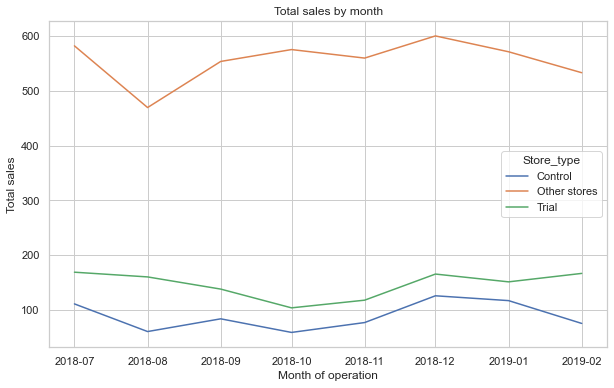

In [22]:
# Make a copy of measureOverTime to work with
measureOverTimeSales = measureOverTime.copy()

# Identifying the store type (Trial, Control, Other stores)
measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Grouping by YEARMONTH and Store_type, calculate mean of totSales
pastSales = measureOverTimeSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Converting YEARMONTH to datetime format and create TransactionMonth
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'], format='%Y%m')
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Ploting using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastSales, x='TransactionMonth', y='totSales', hue='Store_type')
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.show()

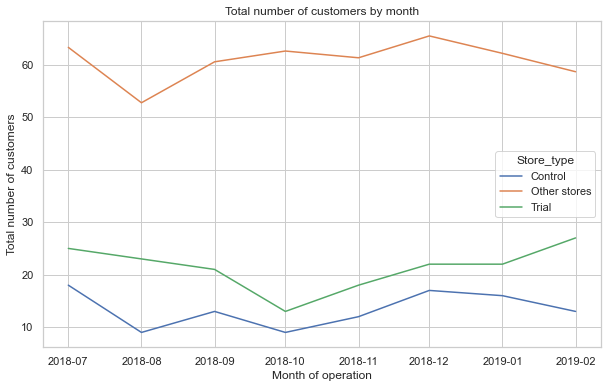

In [23]:
# visualizing for number of customers
# Make a copy of measureOverTime to work with
measureOverTimeCusts = measureOverTime.copy()

# Identifying the store type (Trial, Control, Other stores)
measureOverTimeCusts['Store_type'] = measureOverTimeCusts['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Grouping by YEARMONTH and Store_type, calculate mean of nCustomers
pastCustomers = measureOverTimeCusts.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Converting YEARMONTH to datetime format and create TransactionMonth
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'], format='%Y%m')
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Ploting using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type')
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.show()

# Assessment of Trial

The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an uplift in overall 
chip sales. We’ll start with scaling the control store’s sales to a level similar to control for any differences between 
the two stores outside of the trial period

In [24]:
# Calculating the scaling factor for control sales
scaling_factor_for_control_sales = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) &
                                                    (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum() / \
                                  preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) &
                                                    (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()

# Make a copy of measureOverTime to work with
measureOverTimeSales = measureOverTime.copy()

# Calculating scaled control sales
scaledControlSales = measureOverTimeSales[(measureOverTimeSales['STORE_NBR'] == control_store) &
                                           (measureOverTimeSales['YEARMONTH'] < 201902)].copy()
scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scaling_factor_for_control_sales

In [25]:
scaledControlSales

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxn,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,controlSales
2979,264,201807,111.4,18,18,36,1.0,2.0,3.094444,176.281319
2980,264,201808,61.0,9,9,18,1.0,2.0,3.388889,96.527473
2981,264,201809,84.2,13,13,26,1.0,2.0,3.238462,133.239560
2982,264,201810,59.4,9,9,18,1.0,2.0,3.300000,93.995604
2983,264,201811,77.4,12,12,24,1.0,2.0,3.225000,122.479121
2984,264,201812,126.2,17,17,34,1.0,2.0,3.711765,199.701099
2985,264,201901,117.4,16,16,32,1.0,2.0,3.668750,185.775824


In [26]:
# Calculate the percentage difference between scaled control sales and trial sales
# Select relevant columns from scaledControlSales
scaled_control_sales_subset = scaledControlSales[['YEARMONTH', 'controlSales']]

# Select relevant columns from measureOverTime for the trial store
trial_sales_subset = measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']]

# Merge the two subsets on YEARMONTH
merged_sales_data = pd.merge(scaled_control_sales_subset, trial_sales_subset, on='YEARMONTH', how='inner')

# Calculate percentage difference
merged_sales_data['percentageDiff'] = abs(merged_sales_data['controlSales'] - merged_sales_data['totSales']) / merged_sales_data['controlSales']

In [27]:
merged_sales_data

,YEARMONTH,controlSales,totSales,percentageDiff
0,201807,176.281319,169.2,0.040171
1,201808,96.527473,160.6,0.663775
2,201809,133.239560,138.4,0.038731
3,201810,93.995604,104.2,0.108562
4,201811,122.479121,118.2,0.034938
5,201812,199.701099,165.8,0.169759
6,201901,185.775824,151.6,0.183963


In [28]:
# Calculate standard deviation of percentage differences in the pre-trial period
stdDev = np.std(merged_sales_data[merged_sales_data['YEARMONTH'] < 201902]['percentageDiff'])

# Degrees of freedom for t-distribution
degreesOfFreedom = 7

In [29]:
# Calculate t-value and add TransactionMonth
merged_sales_data['tValue'] = (merged_sales_data['percentageDiff'] - 0) / stdDev
merged_sales_data['TransactionMonth'] = pd.to_datetime(
    merged_sales_data['YEARMONTH'].apply(lambda x: f"{x//100}-{x%100}-01"), format='%Y-%m-%d'
)
t_values_subset = merged_sales_data[(merged_sales_data['YEARMONTH'] < 201905) &
                                 (merged_sales_data['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]

# Find the 95th percentile of the t-distribution
percentile_95 = t.ppf(0.95, df=degreesOfFreedom)

In [30]:
percentile_95

1.894578605061305

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the
control store. Let’s create a more visual version of this by plotting the sales of the control store, the sales of 
the trial stores and the 95th percentile value of sales of the control store.

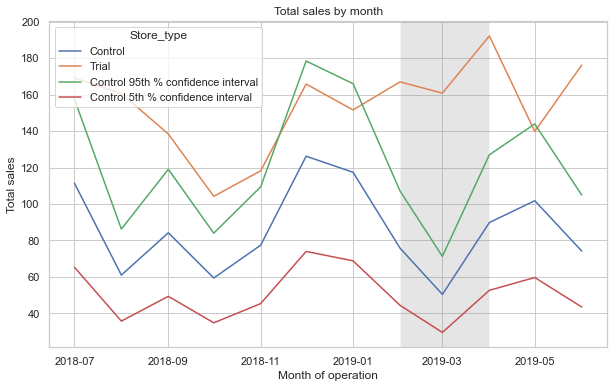

In [31]:
# Make a copy of measureOverTime to work with
measureOverTimeSales = measureOverTime.copy()

# Identify the store type (Trial, Control, Other stores)
measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Group by YEARMONTH and Store_type, calculate mean of totSales
pastSales = measureOverTimeSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to datetime format and create TransactionMonth
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'], format='%Y%m')
pastSales = pastSales[pastSales['Store_type'].isin(['Trial', 'Control'])]

# Calculate control store 95th percentile
pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls95['totSales'] = pastSales_Controls95['totSales'] * (1 + stdDev * 2)
pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Calculate control store 5th percentile
pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls5['totSales'] = pastSales_Controls5['totSales'] * (1 - stdDev * 2)
pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine all assessments
trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Reset index before plotting
trialAssessment = trialAssessment.reset_index(drop=True)

# Plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=trialAssessment, x='TransactionMonth', y='totSales', hue='Store_type')
plt.axvspan(pd.Timestamp('2019-02-01'), pd.Timestamp('2019-04-01'), facecolor='gray', alpha=0.2)
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months.
Let’s have a look at assessing this for number of customers as well.

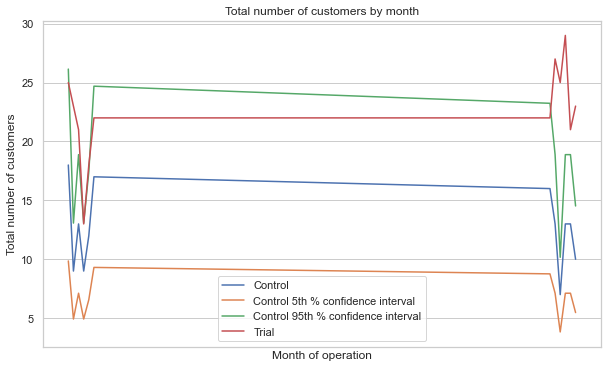

In [32]:
# Scale pre‐trial control customers to match pre‐trial trial store customers
scalingFactorForControlCust = preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == trial_store) & (preTrialMeasures["YEARMONTH"] < 201902),
    "nCustomers"
].sum() / preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == control_store) & (preTrialMeasures["YEARMONTH"] < 201902),
    "nCustomers"
].sum()

# Apply the scaling factor
measureOverTimeCusts_copy = measureOverTimeCusts.copy()
measureOverTimeCusts_copy.loc[measureOverTimeCusts_copy["STORE_NBR"] == control_store, "controlCustomers"] = (
    measureOverTimeCusts_copy.loc[measureOverTimeCusts_copy["STORE_NBR"] == control_store, "nCustomers"] * scalingFactorForControlCust
)
measureOverTimeCusts_copy["Store_type"] = measureOverTimeCusts_copy["STORE_NBR"].apply(
    lambda store: "Trial" if store == trial_store else (
        "Control" if store == control_store else "Other stores"
    )
)

# Calculate the percentage difference between scaled control customers and trial customers
scaledControlCustomers = measureOverTimeCusts_copy[measureOverTimeCusts_copy["STORE_NBR"] == control_store][["YEARMONTH", "controlCustomers"]]
trialCustomers = measureOverTimeCusts_copy[measureOverTimeCusts_copy["STORE_NBR"] == trial_store][["YEARMONTH", "nCustomers"]]
percentageDiff = pd.merge(scaledControlCustomers, trialCustomers, on="YEARMONTH")
percentageDiff["percentageDiff"] = abs(percentageDiff["controlCustomers"] - percentageDiff["nCustomers"]) / percentageDiff["controlCustomers"]

# Calculate the standard deviation and degrees of freedom
stdDev = percentageDiff.loc[percentageDiff["YEARMONTH"] < 201902, "percentageDiff"].std()
degreesOfFreedom = 7

# Create pastCustomers dataframe for Trial and Control stores
pastCustomers = measureOverTimeCusts_copy.groupby(["YEARMONTH", "Store_type"])["nCustomers"].mean().reset_index()
pastCustomers = pastCustomers[pastCustomers["Store_type"].isin(["Trial", "Control"])]

# Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers["Store_type"] == "Control"].copy()
pastCustomers_Controls95["nCustomers"] *= (1 + stdDev * 2)
pastCustomers_Controls95["Store_type"] = "Control 95th % confidence interval"

# Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers["Store_type"] == "Control"].copy()
pastCustomers_Controls5["nCustomers"] *= (1 - stdDev * 2)
pastCustomers_Controls5["Store_type"] = "Control 5th % confidence interval"

# Combine dataframes
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

for store_type, data in trialAssessment.groupby("Store_type"):
    ax.plot(data["YEARMONTH"], data["nCustomers"], label=store_type)

ax.fill_between(
    trialAssessment.loc[(trialAssessment["YEARMONTH"] < 201905) & (trialAssessment["YEARMONTH"] > 201901), "YEARMONTH"],
    y1=0,
    y2=float("inf"),
    color="none",
    alpha=0.2,
)
ax.set_xlabel("Month of operation")
ax.set_ylabel("Total number of customers")
ax.set_title("Total number of customers by month")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.legend()
plt.show()

Let’s repeat finding the control store and assessing the impact of the trial for each of the other two trial
stores

# Trial Store 86

In [33]:
data = df.copy()
# Create a month ID
data['DATE'] = pd.to_datetime(data['DATE'])
data['YEARMONTH'] = data['DATE'].apply(lambda x: x.year * 100 + x.month)

# Calculate measures over time
measureOverTime = data.groupby(["STORE_NBR", "YEARMONTH"]).agg(
    totSales=("TOT_SALES", "sum"),
    nCustomers=("LYLTY_CARD_NBR", "nunique"),
    nTxnPerCust=("TXN_ID", "nunique"),
    nChipsPerTxn=("PROD_QTY", "sum"),
    avgPricePerUnit=("TOT_SALES", "sum")
).reset_index().sort_values(by=["STORE_NBR", "YEARMONTH"])

# Calculate nTxnPerCust and avgPricePerUnit after aggregation
measureOverTime["nTxnPerCust"] = measureOverTime["nTxnPerCust"] / measureOverTime["nCustomers"]
measureOverTime["nChipsPerTxn"] = measureOverTime["nChipsPerTxn"] / measureOverTime["nTxnPerCust"]
measureOverTime["avgPricePerUnit"] = measureOverTime["avgPricePerUnit"] / measureOverTime["totSales"]

# Use the functions for calculating correlation
trial_store = 86
corr_nSales = calculate_correlation(preTrialMeasures, "totSales", trial_store)
corr_nCustomers = calculate_correlation(preTrialMeasures, "nCustomers", trial_store)

# Use the functions for calculating magnitude
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, "totSales", trial_store)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, "nCustomers", trial_store)

# Create a combined score composed of correlation and magnitude
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=["Store1", "Store2"])
score_nSales["scoreNSales"] = score_nSales["corr_measure"] * corr_weight + score_nSales["magnitudeMeasure"] * (1 - corr_weight)

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=["Store1", "Store2"])
score_nCustomers["scoreNCust"] = score_nCustomers["corr_measure"] * corr_weight + score_nCustomers["magnitudeMeasure"] * (1 - corr_weight)

# Combine scores across the drivers
score_Control = pd.merge(score_nSales, score_nCustomers, on=["Store1", "Store2"])
score_Control["finalControlScore"] = score_Control["scoreNSales"] * 0.5 + score_Control["scoreNCust"] * 0.5

# Select control stores based on the highest matching store
# (closest to 1 but not the store itself, i.e. the second ranked highest store)
# Select control store for trial store 86
control_store = score_Control[score_Control["Store1"] == trial_store].sort_values(by="finalControlScore", ascending=False).iloc[1]["Store2"]

print(control_store)

155


Looks like store 155 will be a control store for trial store 86. Again, let’s check visually if the drivers are
indeed similar in the period before the trial. We’ll look at total sales first.

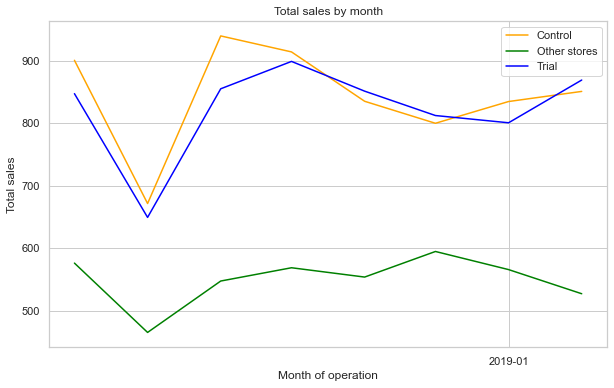

In [34]:
# Create a copy of the measureOverTime DataFrame for visualization
measureOverTimeSales = measureOverTime.copy()

# Add a Store_type column
measureOverTimeSales["Store_type"] = measureOverTimeSales.apply(
    lambda row: "Trial" if row["STORE_NBR"] == trial_store
    else ("Control" if row["STORE_NBR"] == control_store
          else "Other stores"),
    axis=1
)

# Calculate mean total sales by YearMonth and Store_type
pastSales = measureOverTimeSales.groupby(["YEARMONTH", "Store_type"]).agg(
    totSales=("totSales", "mean")
).reset_index()

# Convert YEARMONTH to a datetime format and filter
pastSales["TransactionMonth"] = pd.to_datetime(pastSales["YEARMONTH"].astype(str), format="%Y%m")
pastSales = pastSales[pastSales["YEARMONTH"] < 201903]

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
colors = {"Trial": "blue", "Control": "orange", "Other stores": "green"}

for store_type, data in pastSales.groupby("Store_type"):
    ax.plot(data["TransactionMonth"], data["totSales"], label=store_type, color=colors[store_type])
    ax.set_xlabel("Month of operation")
    ax.set_ylabel("Total sales")
    ax.set_title("Total sales by month")
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

ax.legend()
plt.show()

In [35]:
# Great, sales are trending in a similar way. Let's see number of customers.

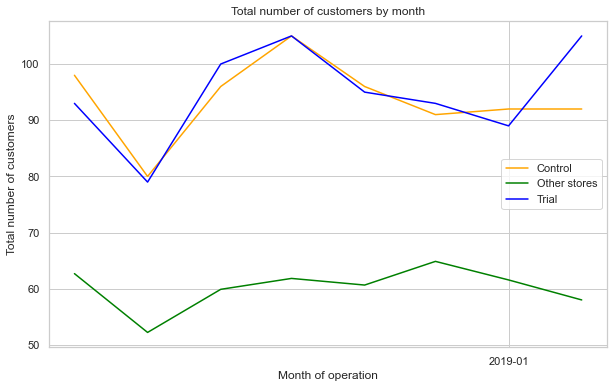

In [36]:
# Create a copy of the measureOverTime DataFrame for visualization
measureOverTimeCusts = measureOverTime.copy()

# Add a Store_type column
measureOverTimeCusts["Store_type"] = measureOverTimeCusts.apply(
    lambda row: "Trial" if row["STORE_NBR"] == trial_store
    else ("Control" if row["STORE_NBR"] == control_store
          else "Other stores"),
    axis=1
)

# Calculate mean number of customers by YearMonth and Store_type
pastCustomers = measureOverTimeCusts.groupby(["YEARMONTH", "Store_type"]).agg(
    numberCustomers=("nCustomers", "mean")
).reset_index()

# Convert YEARMONTH to a datetime format and filter
pastCustomers["TransactionMonth"] = pd.to_datetime(pastCustomers["YEARMONTH"].astype(str), format="%Y%m")
pastCustomers = pastCustomers[pastCustomers["YEARMONTH"] < 201903]

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
colors = {"Trial": "blue", "Control": "orange", "Other stores": "green"}

for store_type, data in pastCustomers.groupby("Store_type"):
    ax.plot(data["TransactionMonth"], data["numberCustomers"], label=store_type, color=colors[store_type])
    ax.set_xlabel("Month of operation")
    ax.set_ylabel("Total number of customers")
    ax.set_title("Total number of customers by month")
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

ax.legend()
plt.show()

In [37]:
# Good, the trend in number of customers is also similar. Let’s now assess the impact of the trial on sales.

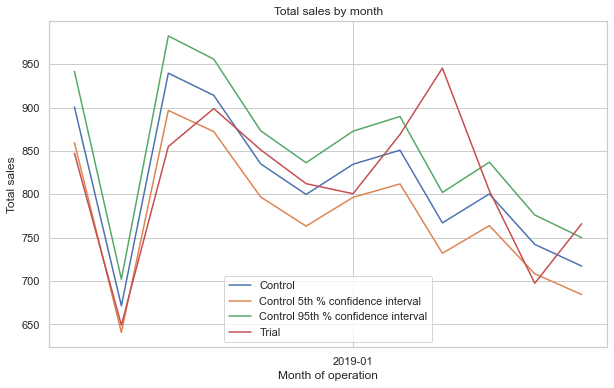

In [38]:
# Scale pre‐trial control sales to match pre‐trial trial store sales
scalingFactorForControlSales = preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == trial_store) & (preTrialMeasures["YEARMONTH"] < 201902),
    "totSales"
].sum() / preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == control_store) & (preTrialMeasures["YEARMONTH"] < 201902),
    "totSales"
].sum()

# Apply the scaling factor
measureOverTimeSales = measureOverTime.copy()
measureOverTimeSales.loc[measureOverTimeSales["STORE_NBR"] == control_store, "controlSales"] = (
    measureOverTimeSales.loc[measureOverTimeSales["STORE_NBR"] == control_store, "totSales"] * scalingFactorForControlSales
)

# Calculate the percentage difference between scaled control sales and trial sales
scaledControlSales = measureOverTimeSales[measureOverTimeSales["STORE_NBR"] == control_store][["YEARMONTH", "controlSales"]]
trialSales = measureOverTimeSales[measureOverTimeSales["STORE_NBR"] == trial_store][["YEARMONTH", "totSales"]]
percentageDiff = pd.merge(scaledControlSales, trialSales, on="YEARMONTH")
percentageDiff["percentageDiff"] = abs(percentageDiff["controlSales"] - percentageDiff["totSales"]) / percentageDiff["controlSales"]

# Calculate the standard deviation and degrees of freedom
stdDev = percentageDiff.loc[percentageDiff["YEARMONTH"] < 201902, "percentageDiff"].std()
degreesOfFreedom = 7

# Create pastSales dataframe for Trial and Control stores
measureOverTimeSales["Store_type"] = measureOverTimeSales["STORE_NBR"].apply(
    lambda store: "Trial" if store == trial_store else (
        "Control" if store == control_store else "Other stores"
    )
)
pastSales = measureOverTimeSales.groupby(["YEARMONTH", "Store_type"])["totSales"].mean().reset_index()
pastSales["TransactionMonth"] = pd.to_datetime(pastSales["YEARMONTH"].astype(str), format="%Y%m")
pastSales = pastSales[pastSales["Store_type"].isin(["Trial", "Control"])]

# Control store 95th percentile
pastSales_Controls95 = pastSales[pastSales["Store_type"] == "Control"].copy()
pastSales_Controls95["totSales"] *= (1 + stdDev * 2)
pastSales_Controls95["Store_type"] = "Control 95th % confidence interval"

# Control store 5th percentile
pastSales_Controls5 = pastSales[pastSales["Store_type"] == "Control"].copy()
pastSales_Controls5["totSales"] *= (1 - stdDev * 2)
pastSales_Controls5["Store_type"] = "Control 5th % confidence interval"

# Combine dataframes
trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

for store_type, data in trialAssessment.groupby("Store_type"):
    ax.plot(data["TransactionMonth"], data["totSales"], label=store_type)

ax.fill_between(
    trialAssessment.loc[(trialAssessment["YEARMONTH"] < 201905) & (trialAssessment["YEARMONTH"] > 201901), "TransactionMonth"],
    y1=0,
    y2=float("inf"),
    color="none",
    alpha=0.2,
)
ax.set_xlabel("Month of operation")
ax.set_ylabel("Total sales")
ax.set_title("Total sales by month")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.legend()
plt.show()

The results show that the trial in store 86 is not significantly different to its control store in the trial period as the 
trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months. Let’s have a look at assessing this for number of customers as well.

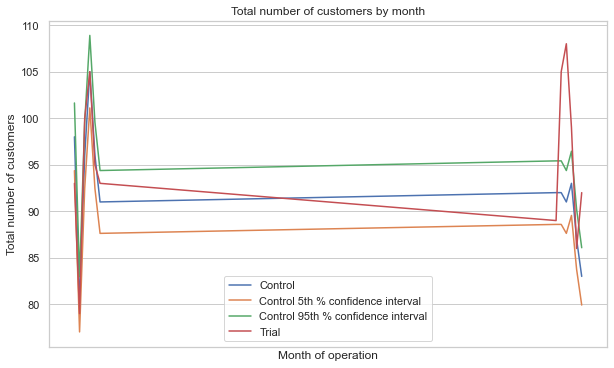

In [39]:
# Scale pre‐trial control customers to match pre‐trial trial store customers
scalingFactorForControlCust = preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == trial_store) & (preTrialMeasures["YEARMONTH"] < 201902),
    "nCustomers"
].sum() / preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == control_store) & (preTrialMeasures["YEARMONTH"] < 201902),
    "nCustomers"
].sum()

# Apply the scaling factor
measureOverTimeCusts_copy = measureOverTimeCusts.copy()
measureOverTimeCusts_copy.loc[measureOverTimeCusts_copy["STORE_NBR"] == control_store, "controlCustomers"] = (
    measureOverTimeCusts_copy.loc[measureOverTimeCusts_copy["STORE_NBR"] == control_store, "nCustomers"] * scalingFactorForControlCust
)
measureOverTimeCusts_copy["Store_type"] = measureOverTimeCusts_copy["STORE_NBR"].apply(
    lambda store: "Trial" if store == trial_store else (
        "Control" if store == control_store else "Other stores"
    )
)

# Calculate the percentage difference between scaled control customers and trial customers
scaledControlCustomers = measureOverTimeCusts_copy[measureOverTimeCusts_copy["STORE_NBR"] == control_store][["YEARMONTH", "controlCustomers"]]
trialCustomers = measureOverTimeCusts_copy[measureOverTimeCusts_copy["STORE_NBR"] == trial_store][["YEARMONTH", "nCustomers"]]
percentageDiff = pd.merge(scaledControlCustomers, trialCustomers, on="YEARMONTH")
percentageDiff["percentageDiff"] = abs(percentageDiff["controlCustomers"] - percentageDiff["nCustomers"]) / percentageDiff["controlCustomers"]

# Calculate the standard deviation and degrees of freedom
stdDev = percentageDiff.loc[percentageDiff["YEARMONTH"] < 201902, "percentageDiff"].std()
degreesOfFreedom = 7

# Create pastCustomers dataframe for Trial and Control stores
pastCustomers = measureOverTimeCusts_copy.groupby(["YEARMONTH", "Store_type"])["nCustomers"].mean().reset_index()
pastCustomers = pastCustomers[pastCustomers["Store_type"].isin(["Trial", "Control"])]

# Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers["Store_type"] == "Control"].copy()
pastCustomers_Controls95["nCustomers"] *= (1 + stdDev * 2)
pastCustomers_Controls95["Store_type"] = "Control 95th % confidence interval"

# Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers["Store_type"] == "Control"].copy()
pastCustomers_Controls5["nCustomers"] *= (1 - stdDev * 2)
pastCustomers_Controls5["Store_type"] = "Control 5th % confidence interval"

# Combine dataframes
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

for store_type, data in trialAssessment.groupby("Store_type"):
    ax.plot(data["YEARMONTH"], data["nCustomers"], label=store_type)

ax.fill_between(
    trialAssessment.loc[(trialAssessment["YEARMONTH"] < 201905) & (trialAssessment["YEARMONTH"] > 201901), "YEARMONTH"],
    y1=0,
    y2=float("inf"),
    color="none",
    alpha=0.2,
)
ax.set_xlabel("Month of operation")
ax.set_ylabel("Total number of customers")
ax.set_title("Total number of customers by month")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.legend()
plt.show()

It looks like the number of customers is significantly higher in all of the three months. This seems to
suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but
as we saw, sales were not significantly higher. We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices, impacting the results.

# Trial Store 88

In [40]:
data = df.copy()
# Create a month ID
data['DATE'] = pd.to_datetime(data['DATE'])
data['YEARMONTH'] = data['DATE'].apply(lambda x: x.year * 100 + x.month)

# Calculate measures over time
measureOverTime = data.groupby(["STORE_NBR", "YEARMONTH"]).agg(
    totSales=("TOT_SALES", "sum"),
    nCustomers=("LYLTY_CARD_NBR", "nunique")
).reset_index().sort_values(by=["STORE_NBR", "YEARMONTH"])

# Calculate nTxnPerCust, nChipsPerTxn, and avgPricePerUnit
nTxnPerCust = data.groupby(["STORE_NBR", "YEARMONTH"]).apply(lambda x: x["TXN_ID"].nunique() / x["LYLTY_CARD_NBR"].nunique()).reset_index(name="nTxnPerCust")
nChipsPerTxn = data.groupby(["STORE_NBR", "YEARMONTH"]).apply(lambda x: x["PROD_QTY"].sum() / x["TXN_ID"].nunique()).reset_index(name="nChipsPerTxn")
avgPricePerUnit = data.groupby(["STORE_NBR", "YEARMONTH"]).apply(lambda x: x["TOT_SALES"].sum() / x["PROD_QTY"].sum()).reset_index(name="avgPricePerUnit")

# Merge additional calculations into the measureOverTime dataframe
measureOverTime = pd.merge(measureOverTime, nTxnPerCust, on=["STORE_NBR", "YEARMONTH"])
measureOverTime = pd.merge(measureOverTime, nChipsPerTxn, on=["STORE_NBR", "YEARMONTH"])
measureOverTime = pd.merge(measureOverTime, avgPricePerUnit, on=["STORE_NBR", "YEARMONTH"])

# Use the functions for calculating correlation
trial_store = 88
corr_nSales = calculate_correlation(preTrialMeasures, "totSales", trial_store)
corr_nCustomers = calculate_correlation(preTrialMeasures, "nCustomers", trial_store)

# Use the functions for calculating magnitude
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, "totSales", trial_store)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, "nCustomers", trial_store)

# Create a combined score composed of correlation and magnitude
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=["Store1", "Store2"])
score_nSales["scoreNSales"] = score_nSales["corr_measure"] * corr_weight + score_nSales["magnitudeMeasure"] * (1 - corr_weight)

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=["Store1", "Store2"])
score_nCustomers["scoreNCust"] = score_nCustomers["corr_measure"] * corr_weight + score_nCustomers["magnitudeMeasure"] * (1 - corr_weight)

# Combine scores across the drivers
score_Control = pd.merge(score_nSales, score_nCustomers, on=["Store1", "Store2"])
score_Control["finalControlScore"] = score_Control["scoreNSales"] * 0.5 + score_Control["scoreNCust"] * 0.5

# Select control store based on the highest matching store
# Select control store for trial store 88
control_store = score_Control[score_Control["Store1"] == trial_store].sort_values(by="finalControlScore", ascending=False)["Store2"].iloc[1]

print("Selected control store:", control_store)

Selected control store: 217


We’ve now found store 217 to be a suitable control store for trial store 88. Again, let’s check visually if the drivers are
indeed similar in the period before the trial. We’ll look at total sales first

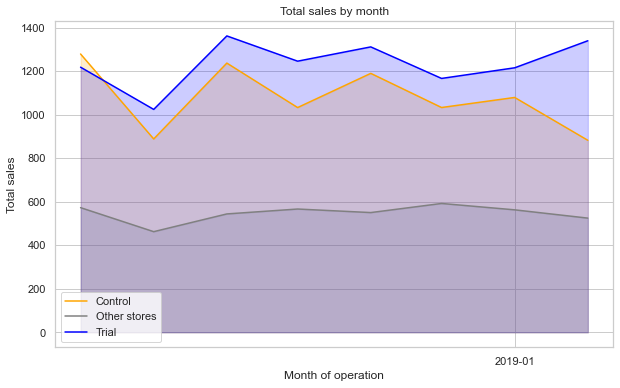

In [41]:
# Visual checks on trends based on the drivers
measureOverTimeSales = measureOverTime.copy()

# Assign Store_type
measureOverTimeSales["Store_type"] = measureOverTimeSales["STORE_NBR"].apply(
    lambda store: "Trial" if store == trial_store else (
        "Control" if store == control_store else "Other stores"
    )
)

# Calculate mean total sales by YEARMONTH and Store_type
pastSales = measureOverTimeSales.groupby(["YEARMONTH", "Store_type"])["totSales"].mean().reset_index()

# Convert YEARMONTH to a datetime format
pastSales["TransactionMonth"] = pd.to_datetime(pastSales["YEARMONTH"].astype(str), format="%Y%m")

# Filter data for months before 201903
pastSales = pastSales[pastSales["YEARMONTH"] < 201903]

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
colors = {"Trial": "blue", "Control": "orange", "Other stores": "gray"}

for store_type, data in pastSales.groupby("Store_type"):
    ax.plot(data["TransactionMonth"], data["totSales"], label=store_type, color=colors[store_type])
    ax.fill_between(data["TransactionMonth"], data["totSales"], color=colors[store_type], alpha=0.2)

ax.set_xlabel("Month of operation")
ax.set_ylabel("Total sales")
ax.set_title("Total sales by month")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.legend()
plt.show()

In [42]:
# the trial and control stores have different total sales. Next, number of customers.

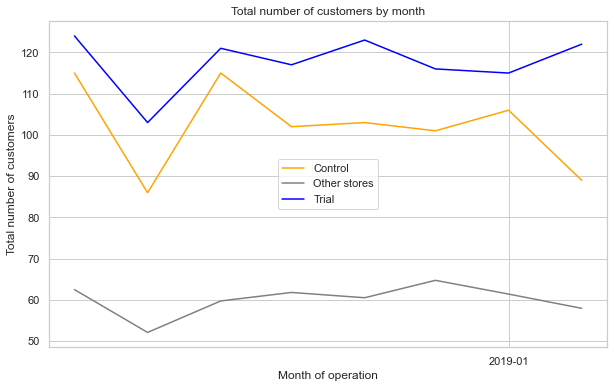

In [43]:
# Visual checks on trends based on the drivers
measureOverTimeCusts_copy = measureOverTimeCusts.copy()

# Assign Store_type
measureOverTimeCusts_copy["Store_type"] = measureOverTimeCusts_copy["STORE_NBR"].apply(
    lambda store: "Trial" if store == trial_store else (
        "Control" if store == control_store else "Other stores"
    )
)

# Calculate mean number of customers by YEARMONTH and Store_type
pastCustomers = measureOverTimeCusts_copy.groupby(["YEARMONTH", "Store_type"])["nCustomers"].mean().reset_index()

# Convert YEARMONTH to a datetime format
pastCustomers["TransactionMonth"] = pd.to_datetime(pastCustomers["YEARMONTH"].astype(str), format="%Y%m")

# Filter data for months before 201903
pastCustomers = pastCustomers[pastCustomers["YEARMONTH"] < 201903]

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
colors = {"Trial": "blue", "Control": "orange", "Other stores": "gray"}

for store_type, data in pastCustomers.groupby("Store_type"):
    ax.plot(data["TransactionMonth"], data["nCustomers"], label=store_type, color=colors[store_type])

ax.set_xlabel("Month of operation")
ax.set_ylabel("Total number of customers")
ax.set_title("Total number of customers by month")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.legend()
plt.show()

In [44]:
# Total number of customers of the control and trial stores are not similar. Let’s now assess the impact of the trial on sales.

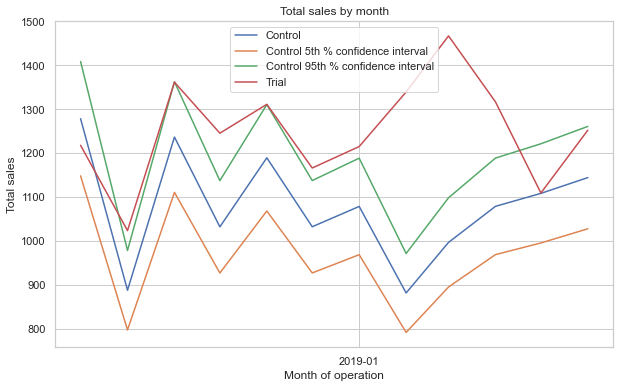

In [45]:
# Scale pre‐trial control sales to match pre‐trial trial store sales
scalingFactorForControlSales = preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == trial_store) & (preTrialMeasures["YEARMONTH"] < 201902),
    "totSales"
].sum() / preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == control_store) & (preTrialMeasures["YEARMONTH"] < 201902),
    "totSales"
].sum()

# Apply the scaling factor
measureOverTimeSales = measureOverTime.copy()
measureOverTimeSales.loc[measureOverTimeSales["STORE_NBR"] == control_store, "controlSales"] = (
    measureOverTimeSales.loc[measureOverTimeSales["STORE_NBR"] == control_store, "totSales"] * scalingFactorForControlSales
)

# Calculate the percentage difference between scaled control sales and trial sales
scaledControlSales = measureOverTimeSales[measureOverTimeSales["STORE_NBR"] == control_store][["YEARMONTH", "controlSales"]]
trialSales = measureOverTimeSales[measureOverTimeSales["STORE_NBR"] == trial_store][["YEARMONTH", "totSales"]]
percentageDiff = pd.merge(scaledControlSales, trialSales, on="YEARMONTH")
percentageDiff["percentageDiff"] = abs(percentageDiff["controlSales"] - percentageDiff["totSales"]) / percentageDiff["controlSales"]

# Calculate the standard deviation and degrees of freedom
stdDev = percentageDiff.loc[percentageDiff["YEARMONTH"] < 201902, "percentageDiff"].std()
degreesOfFreedom = 7

# Create pastSales dataframe for Trial and Control stores
measureOverTimeSales["Store_type"] = measureOverTimeSales["STORE_NBR"].apply(
    lambda store: "Trial" if store == trial_store else (
        "Control" if store == control_store else "Other stores"
    )
)
pastSales = measureOverTimeSales.groupby(["YEARMONTH", "Store_type"])["totSales"].mean().reset_index()
pastSales["TransactionMonth"] = pd.to_datetime(pastSales["YEARMONTH"].astype(str), format="%Y%m")
pastSales = pastSales[pastSales["Store_type"].isin(["Trial", "Control"])]

# Control store 95th percentile
pastSales_Controls95 = pastSales[pastSales["Store_type"] == "Control"].copy()
pastSales_Controls95["totSales"] *= (1 + stdDev * 2)
pastSales_Controls95["Store_type"] = "Control 95th % confidence interval"

# Control store 5th percentile
pastSales_Controls5 = pastSales[pastSales["Store_type"] == "Control"].copy()
pastSales_Controls5["totSales"] *= (1 - stdDev * 2)
pastSales_Controls5["Store_type"] = "Control 5th % confidence interval"

# Combine dataframes
trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

for store_type, data in trialAssessment.groupby("Store_type"):
    ax.plot(data["TransactionMonth"], data["totSales"], label=store_type)

ax.fill_between(
    trialAssessment.loc[(trialAssessment["YEARMONTH"] < 201905) & (trialAssessment["YEARMONTH"] > 201901), "TransactionMonth"],
    y1=0,
    y2=float("inf"),
    color="none",
    alpha=0.2,
)
ax.set_xlabel("Month of operation")
ax.set_ylabel("Total sales")
ax.set_title("Total sales by month")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.legend()
plt.show()

The results show that the trial in store 88 is significantly different to its control store in the trial period as the
trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the
three trial months. Let’s have a look at assessing this for number of customers as well.

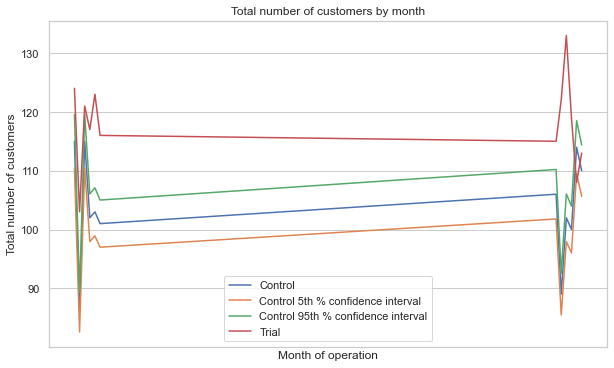

In [46]:
# Scale pre‐trial control customers to match pre‐trial trial store customers
scalingFactorForControlCust = preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == trial_store) & (preTrialMeasures["YEARMONTH"] < 201902),
    "nCustomers"
].sum() / preTrialMeasures.loc[
    (preTrialMeasures["STORE_NBR"] == control_store) & (preTrialMeasures["YEARMONTH"] < 201902),
    "nCustomers"
].sum()

# Apply the scaling factor
measureOverTimeCusts_copy = measureOverTimeCusts.copy()
measureOverTimeCusts_copy.loc[measureOverTimeCusts_copy["STORE_NBR"] == control_store, "controlCustomers"] = (
    measureOverTimeCusts_copy.loc[measureOverTimeCusts_copy["STORE_NBR"] == control_store, "nCustomers"] * scalingFactorForControlCust
)
measureOverTimeCusts_copy["Store_type"] = measureOverTimeCusts_copy["STORE_NBR"].apply(
    lambda store: "Trial" if store == trial_store else (
        "Control" if store == control_store else "Other stores"
    )
)

# Calculate the percentage difference between scaled control customers and trial customers
scaledControlCustomers = measureOverTimeCusts_copy[measureOverTimeCusts_copy["STORE_NBR"] == control_store][["YEARMONTH", "controlCustomers"]]
trialCustomers = measureOverTimeCusts_copy[measureOverTimeCusts_copy["STORE_NBR"] == trial_store][["YEARMONTH", "nCustomers"]]
percentageDiff = pd.merge(scaledControlCustomers, trialCustomers, on="YEARMONTH")
percentageDiff["percentageDiff"] = abs(percentageDiff["controlCustomers"] - percentageDiff["nCustomers"]) / percentageDiff["controlCustomers"]

# Calculate the standard deviation and degrees of freedom
stdDev = percentageDiff.loc[percentageDiff["YEARMONTH"] < 201902, "percentageDiff"].std()
degreesOfFreedom = 7

# Create pastCustomers dataframe for Trial and Control stores
pastCustomers = measureOverTimeCusts_copy.groupby(["YEARMONTH", "Store_type"])["nCustomers"].mean().reset_index()
pastCustomers = pastCustomers[pastCustomers["Store_type"].isin(["Trial", "Control"])]

# Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers["Store_type"] == "Control"].copy()
pastCustomers_Controls95["nCustomers"] *= (1 + stdDev * 2)
pastCustomers_Controls95["Store_type"] = "Control 95th % confidence interval"

# Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers["Store_type"] == "Control"].copy()
pastCustomers_Controls5["nCustomers"] *= (1 - stdDev * 2)
pastCustomers_Controls5["Store_type"] = "Control 5th % confidence interval"

# Combine dataframes
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

for store_type, data in trialAssessment.groupby("Store_type"):
    ax.plot(data["YEARMONTH"], data["nCustomers"], label=store_type)

ax.fill_between(
    trialAssessment.loc[(trialAssessment["YEARMONTH"] < 201905) & (trialAssessment["YEARMONTH"] > 201901), "YEARMONTH"],
    y1=0,
    y2=float("inf"),
    color="none",
    alpha=0.2,
)
ax.set_xlabel("Month of operation")
ax.set_ylabel("Total number of customers")
ax.set_title("Total number of customers by month")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.legend()
plt.show()

Total number of customers in the trial period for the trial store is significantly higher than the control store which indicates a positive trial effect.

Conclusion

We’ve found control stores 264, 155, 217 for trial stores 77, 86 and 88 respectively.
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the
three trial months but this is not the case for trial store 86. We can check with the client if the implementation
of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.